# MediaCloud API Python interface for ReThink Media's 9/11 report
Functions for ReThink's analysis of media coverage surrounding the 20th anniversary of 9/11 will be developed within this notebook.

In [19]:
# importing dependencies for MediaCloud API
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import mediacloud.api
from dateutil import parser
import time
import matplotlib.pyplot as plt

# loading config from .env file
load_dotenv()

True

In [20]:
# reading API key from .env
mc_api_key = os.getenv("MC_API_KEY")

# instantiating MediaCloud API
mc = mediacloud.api.MediaCloud(mc_api_key)
mediacloud.__version__

'3.12.4'

In [ ]:
# verifying API connection by printing some high-level stats
mc.stats()

## Defining sources and search strings
These source dicts and search strings will be used in analysis, and passed into the functions below.

In [15]:
# defining sources and ID's in MediaCloud API
# commented sources cannot be found in MediaCloud's Source Manager
sources = {
    "Washington Post": 2,
    "New York Times": 1,
    "USA Today": 4,
    "LA Times": 6,
    "Bloomberg": 40944,
    "Christian Science Monitor": 3,
    "New York Daily News": 8,
    "Star Ledger (NJ)": 16,
    "The Philadelphia Inquirer (PA)": 18,
    "The Pittsburgh Post-Gazette (PA)": 45,
    "PennLive/Patriot-News (PA)": 662863,
    "The Day (CT)": 76581,
    "Hartford Courant (CT)": 59,
    "Baltimore Sun (MD)": 34,
    "The Capital Gazette (MD)": 70310,
    "The Virginian-Pilot (VA)": 55,
    "The Richmond Times-Dispatch (VA)": 53,
    "Boston Globe (MA)": 15,
    "Portland Press Herald (ME)": 366984,
    "Houston Chronicle (TX)": 10,
    "Austin American Statesman (TX)": 62,
    "Atlanta Journal Constitution (GA)": 22916,
    "Raleigh News and Observer (NC)": 58,
    "The Cleveland Plain Dealer (OH)": 662541
}

novetta_sources = {
    "Associated Press": 1154,
    "Black Agenda Report": 26040,
    "Bustle": 98755,
    "News One": 24661,
    "NPR": 1096,
    "PBS NewsHour": 271188,
    "Politico": 18268,
    "The Root": 368082,
    "Vice": 26164,
    "Al Monitor": 102745,
    "Al Jazeera English": 1148,
    "Buzzfeed": 6218,
    "Chicago Tribune": 9,
    "CNN Wire": 1095,
    "Fox News": 1092,
    "Houston Chronicle": 10,
    "HuffPost": 27502,
    "LA Times": 6,
    "Mic": 109076,
    "Middle East Eye": 107733,
    "Middle East Monitor": 97329,
    "Newsweek": 56510,
    "Reuters News": 4442,
    "Roll Call": 19854,
    "Slate": 4425,
    "Talking Points Memo": 113,
    "The Arizona Republic": 158115,
    "The Atlanta Journal Constitution": 22916,
    "The Atlantic": 1110,
    "The Boston Globe": 15,
    "Christian Science Monitor": 3,
    "The Daily Beast": 1707,
    "The Express Tribune (Pakistan)": 25888,
    "The Hill": 18364,
    "The Intercept": 269138,
    "The Miami Herald": 28,
    "New York Times": 1,
    "The Wall Street Journal": 1150,
    "The Washington Post": 2,
    "The Washington Times": 101,
    "US News and World Report": 1100,
    "USA Today": 4,
    "Vox": 104828,
    "Defense News": 39177,
    "Defense One": 69881,
    "War is Boring": 97642,
    "War on the Rocks": 72738
}

In [4]:
# defining search strings. Search strings must be enclosed by parentheses for MediaCloud API to properly search.
# general 9/11 search string
sep11_search = '("9/11" OR "September 11th" OR "September 11" OR \
(("terrorist attack" OR "terrorist attacks" OR "Al Qaeda") AND "New York") OR \
"twin towers" OR "world trade center" OR "bin laden" OR "ground zero" OR "WTC")'

# endless war/drone killings/etc search string
endless_war_search = '("endless war" OR "forever war" OR "perpetual war" OR \
"foreign policy" OR "war on terror” OR "Pentagon budget" OR \
(("Military budget" OR "military spending" OR "defense budget" OR "defense spending") AND \
(“United States” OR American OR Pentagon OR America OR “U.S.”)) OR \
"war powers" OR "AUMF" OR "Authorization for use of military force” OR \
((drone OR drones OR “unmanned aerial vehicle” OR “unmanned aerial vehicles”) AND \
(terror OR terrorist OR terrorists OR ISIS OR ISIL OR “Islamic State” OR armed OR \
weaponize OR weaponized OR weaponise OR weaponised OR attack OR technology OR \
Afghanistan OR “civilian casualty” OR “civilian casualties”)) OR \
“targeted killing” OR “targeted killings”)'

# racial/religious profiling search string
profiling_search = "(((muslim OR islam* OR arab OR south asia* OR mosque OR imam OR sikh) near50 \
(profil* OR discriminat* OR no fly list OR no-fly list OR islamophobia OR FBI OR radical* OR terror* \
OR jihad* OR homegrown OR home grown OR home-grown)) OR End Racial Profiling Act OR ERPA OR \
((homegrown OR home grown OR home-grown) AND (terror* OR radical*)) OR (sharia OR shariah OR sha'ariah \
OR sh'ariah OR shari'ah OR shari'a) OR Terry Jones OR muslim ban)"

## Utility functions
Functions that set up MediaCloud API calls, formatting inputs, etc., for general use in the rest of the functions.

In [5]:
# defining API key, instantiating MediaCloud API
def init_mc_api(api_key=None):
    
    # importing necessary modules
    from dotenv import load_dotenv
    import os
    import mediacloud.api
    
    # loading environment variables from .env file
    load_dotenv()
    
    # if no API key is passed, function assumes API key is defined in .env file as MC_API_KEY
    if not api_key:
        api_key = os.getenv("MC_API_KEY")
    
    # returning API instance
    return mediacloud.api.MediaCloud(api_key)

In [6]:
# formatting date ranges for MediaCloud API calls.
# required arguments: MediaCloud API instance (from init_mc_api) and date range, eg ["8/1/2021", "9/30/2021"]
def clean_api_date(mediacloud_api, date_range, verbose=False):
    
    # importing necessary modules
    from datetime import datetime
    from dateutil import parser
    
    # making sure two dates are passed into the function
    assert len(date_range) == 2, "Please provide both a start and end date for the date interval."
    
    # parsing dates, returning API date range clause
    start_date = parser.parse(date_range[0])
    end_date = parser.parse(date_range[1])
    if verbose:
        print(f"Date range: between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}")
    return mediacloud_api.dates_as_query_clause(start_date, end_date)

## Story count for multiple sources:
Defining a function to count the number of stories about a topic that is passed into the function. Pass a query and a dictionary of source names and MediaCloud media ID's into the function, and it will return a pandas DataFrame with each source's relevant stories, total stories, and attention to the passed query, measured by percent coverage. You can also pass a range of dates into the function to make your search more specific. 

In [34]:
# building a function to search a string among the sources given
def search_sources(query, sources, date_range=None, api_key=None, verbose=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # ensuring the query is a string
    query = str(query)
    print(f"Query: {query}")
    
    # ensuring sources are given in a dict
    assert type(sources) == dict, "Please provide the sources in a dict, in the format <Source Name>: <MediaCloud ID>"
    
    # initializing dataframe to store the query data
    import pandas as pd
    import numpy as np
    story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)", "Story URLs"])
    story_counts.index.name = "MediaCloud ID"
    
    # going through each source and querying relevant and total stories
    for source_name in sources:
        if verbose:
            print(f"{source_name}:")
        
        # defining queries for topic and total stories
        api_query = f'{query} and media_id:{sources[source_name]}'
        total_query = f'media_id:{sources[source_name]}'
        
        # API calls to count relevant and total stories
        relevant_stories = mc.storyCount(api_query, api_date_range)['count']
        total_stories = mc.storyCount(total_query, api_date_range)['count']
        
        # getting urls for a sample of 20 stories relevant to the query
        stories = mc.storyList(api_query, api_date_range, sort=mc.SORT_RANDOM)
        story_urls = [story['url'] for story in stories]
        
        # appending data to dataframe
        try:
            attention = (relevant_stories / total_stories) * 100
        except ZeroDivisionError:
            attention = np.nan
        story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention, story_urls]
        
        # printing story count and attention
        if verbose:
            print(f"{relevant_stories} stories about {query}, {total_stories} total")
            if not np.isnan(attention):
                print(f"{attention}% of stories are about {query}\n")
            else:
                print("")
    
    return story_counts

In [35]:
# defining query
query = sep11_search
query = endless_war_search
# query = profiling_search

# running and timing function
import time
start_time = time.time()
df = search_sources(query, novetta_sources, date_range=["8/1/2021", "9/30/2021"])
end_time = time.time()
print(f"Time: {round(end_time-start_time, 2)} s")

# printing dataframe output from function, sorting by decreasing attention
df.sort_values(by="Attention (%)", ascending=False)

Query: ("endless war" OR "forever war" OR "perpetual war" OR "foreign policy" OR "war on terror” OR "Pentagon budget" OR (("Military budget" OR "military spending" OR "defense budget" OR "defense spending") AND (“United States” OR American OR Pentagon OR America OR “U.S.”)) OR "war powers" OR "AUMF" OR "Authorization for use of military force” OR ((drone OR drones OR “unmanned aerial vehicle” OR “unmanned aerial vehicles”) AND (terror OR terrorist OR terrorists OR ISIS OR ISIL OR “Islamic State” OR armed OR weaponize OR weaponized OR weaponise OR weaponised OR attack OR technology OR Afghanistan OR “civilian casualty” OR “civilian casualties”)) OR “targeted killing” OR “targeted killings”)


/home/lana-e/anaconda3/envs/mediacloud/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Time: 104.99 s


,Name,Relevant Stories,Total Stories,Attention (%),Story URLs
MediaCloud ID,,,,,
72738,War on the Rocks,1,2,50.000000,[https://warontherocks.com/2021/09/the-evolvin...
39177,Defense News,104,415,25.060241,[http://feedproxy.google.com/~r/defense-news/a...
69881,Defense One,66,277,23.826715,[https://www.defenseone.com/threats/2021/09/to...
269138,The Intercept,41,236,17.372881,[https://theintercept.com/2021/08/26/daniel-ha...
102745,Al Monitor,106,666,15.915916,[https://www.al-monitor.com/originals/2021/09/...
18268,Politico,217,2024,10.721344,[https://www.politico.com/newsletters/national...
107733,Middle East Eye,8,90,8.888889,[http://www.middleeasteye.net/news/us-senators...
1110,The Atlantic,46,612,7.516340,[https://www.theatlantic.com/international/arc...
1148,Al Jazeera English,153,2272,6.734155,[https://www.aljazeera.com/opinions/2021/9/9/t...


## Word clouds
This function takes a query and produces a word cloud, a visualization of the most popular words within stories relevant to the query.

In [11]:
# adapting simple_word_cloud() function from Laura's previous code
def word_cloud(query, sources, date_range, save_img=False, filename=None,
               custom_stopwords=None, api_key=None, verbose=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query, sources, and date_range for API
    assert type(query) == str, "Please input a string as the query."
    media_ids = list(sources.values())
    api_media_ids = " OR ".join([f"media_id:{media_id}" for media_id in media_ids])
    
    api_query = f"{query} and ({api_media_ids})"
    if verbose:
        print(f"Query: {api_query}")

    # building term/document matrix, separating word list from word matrix
    story_count = mc.storyCount(api_query, api_date_range)["count"]
    doc_term_matrix = mc.storyWordMatrix(api_query, api_date_range, rows=story_count, max_words=100)
    word_list = doc_term_matrix["word_list"]
    word_matrix = doc_term_matrix["word_matrix"]
    top_words = [word[1] for word in word_list]
    
    # aggregating word frequencies in each document
    word_freqs = {}
    for word_id in range(len(top_words)):
        word_freqs[word_id] = 0
        for story in word_matrix:
            if str(word_id) in word_matrix[story]:
                word_freqs[word_id] += word_matrix[story][str(word_id)]
            else:
                continue
        word_freqs[top_words[word_id]] = word_freqs.pop(word_id)
    
    # building wordcloud
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)
    wc_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=75, prefer_horizontal=1.0)
    word_cloud.fit_words(word_freqs)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_img:
        if filename:
            word_cloud.to_file(filename)
        else:
            word_cloud.to_file("wordcloud.png")
    return wc_fig

Query: ("endless war" OR "forever war" OR "perpetual war" OR "foreign policy" OR "war on terror” OR "Pentagon budget" OR (("Military budget" OR "military spending" OR "defense budget" OR "defense spending") AND (“United States” OR American OR Pentagon OR America OR “U.S.”)) OR "war powers" OR "AUMF" OR "Authorization for use of military force” OR ((drone OR drones OR “unmanned aerial vehicle” OR “unmanned aerial vehicles”) AND (terror OR terrorist OR terrorists OR ISIS OR ISIL OR “Islamic State” OR armed OR weaponize OR weaponized OR weaponise OR weaponised OR attack OR technology OR Afghanistan OR “civilian casualty” OR “civilian casualties”)) OR “targeted killing” OR “targeted killings”) and (media_id:2 OR media_id:1 OR media_id:4 OR media_id:6 OR media_id:40944 OR media_id:3 OR media_id:8 OR media_id:16 OR media_id:18 OR media_id:45 OR media_id:662863 OR media_id:76581 OR media_id:59 OR media_id:34 OR media_id:70310 OR media_id:55 OR media_id:53 OR media_id:15 OR media_id:366984 OR 

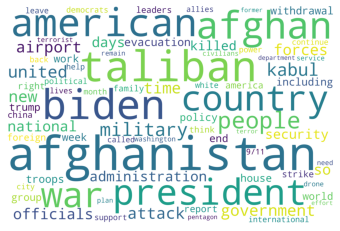

Time to run: 32.32 s


In [14]:
# testing wordcloud function
query = sep11_search
query = endless_war_search
# query = profiling_search # this query takes a really long time to run
date_range = ["8/1/2021", "9/30/2021"]

# running and timing function
import time
start_time = time.time()
test = word_cloud(query, sources, date_range, save_img=True, filename="wordcloud_endlesswar.png", verbose=True)
end_time = time.time()

print(f"Time to run: {round(end_time - start_time, 2)} s")

## Attention over time plots:
This is a function to map media attention of different issues over time. Pass queries, MediaCloud media ID's of sources, and the date range that you would like to plot into the function, and the output will be one plot, with each query's attention over time plotted against each other. You can adjust the figure size as an argument for the function as well.

If you would like to save the plot as an image, the bottom cell of this section contains the code to do so.

In [ ]:
# function to plot attention over time for one or more queries
def attention_plots(queries, sources, date_range, api_key=None, fig_size=(8,4), verbose=False):
    
    # initializing MediaCloud API and cleaning date_range
    mc = init_mc_api(api_key=api_key)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query for plots
    if type(queries) == str:
        queries = [queries]
    else:
        assert type(queries)==list, "Please pass either a list or string of queries into this function."
        
    # formatting media_ids for API query
    media_ids = list(sources.values())
    api_media_ids = " OR ".join(f"media_id:{media_id}" for media_id in media_ids)
    
    # looping over each query and adding attention vs time plot to figure
    import matplotlib.pyplot as plt
    figure = plt.figure(figsize=fig_size)
    i = 1
    for query in queries:
        if verbose:
            print(f"Query {i}: {query}")
        
        # defining query parameters
        relevant_query = f"{query} and ({api_media_ids})"
        total_query = f"({api_media_ids})"
        
        # making API calls for relevant and total story counts (by day)
        relevant_results = mc.storyCount(relevant_query, api_date_range, split=True, split_period='day')['counts']
        if not relevant_results:
            print(f"0 results for {query} between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}.")
            continue
        total_results = mc.storyCount(total_query, api_date_range, split=True, split_period='day')['counts']
        
        # creating dataframes for query and total results
        import pandas as pd
        relevant_df = pd.DataFrame(relevant_results)
        relevant_df["date"] = pd.to_datetime(relevant_df["date"])
        total_df = pd.DataFrame(total_results)
        total_df["date"] = pd.to_datetime(total_df["date"])
        
        # joining dataframes on date, filling missing dates from query with zeros
        join_df = total_df.merge(relevant_df, how="outer", on="date", suffixes=("_total", "_relevant"))
        join_df["count_relevant"] = join_df["count_relevant"].fillna(0).astype(int)
        join_df = join_df[["date", "count_total", "count_relevant"]]
        
        # calculating attention
        join_df["attention"] = (join_df["count_relevant"] / join_df["count_total"]) * 100
        
        # plotting attention over time
        plt.plot(join_df["date"], join_df["attention"], '-', label=f"Query {i}")
        
        i += 1
    
    # setting parameters for plot
    plt.suptitle("Attention over time")
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("Attention in sources (%)")
    plt.xticks(rotation=60)
    plt.show()
    return figure

In [ ]:
# testing attention_plots function
# defining queries
queries = ['"9/11"', '"afghanistan"']
queries = '"9/11" OR "afghanistan"'
queries = [sep11_search, endless_war_search, profiling_search, "afghanistan"]

# defining date range
date_range = ["8/1/2021", "9/30/2021"]

# running and timing function
import time
start_time = time.time()
test_fig = attention_plots(queries, sources, date_range, verbose=False)
end_time = time.time()
print(f"Time to run: {round(end_time-start_time, 2)} s")

In [ ]:
# Save the test_fig from the cell above as an image. Adjust the img_path and img_name variables as necessary.
img_path = "/home/lana-e/Code/rethink/rethink-mediacloud/notebooks/"
img_name = "test_fig"
test_fig.savefig(img_path + img_name, bbox_inches="tight", facecolor="w")

In [27]:
?mc.storyList